In [114]:
import pandas as pd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import string
from multiprocessing import Pool, cpu_count
from string import punctuation
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import nltk
#from gensim import corpora, models
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.lda import LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import seaborn as sns


In [115]:
pwd = os.getcwd()
df = pd.read_csv(pwd + "/data/reviews_amazon.csv")
df.head()

,Unnamed: 0,date,reviewNo,employeeType,position,summary,pro,con,advice,overallStar,workLifeStar,cultureStar,careerOppStar,comBenefitsStar,srManagementStar,reviewLink
0,1,"Feb 7, 2017",empReview_13664891,Current Employee - Software Development Engineer,I have been working at Amazon (More than a year),Kinda crappy,* Pay is good* Non idiotic approach to enginee...,* The company activly encourages everyone to t...,"I'm used to work being something like ""Hello _...",3.0,3.0,3.0,3.0,3.0,3.0,https://www.glassdoor.com/Reviews/Amazon-Revie...
1,2,"Mar 1, 2017",empReview_13996510,Former Employee - Anonymous Employee,I worked at Amazon part-time,Fulfillment,"Great coworkers, always moving, and easy work .",Can be held over for up to 2 additional hours.,Stop employees from hiding in the restroom .,4.0,4.0,4.0,4.0,4.0,4.0,https://www.glassdoor.com/Reviews/Amazon-Revie...
2,3,"Mar 1, 2017",empReview_13997995,Current Employee - Anonymous Employee,None,Good company if you do your job,Decent pay for a job that isn't too hard.,If you don't like long days with little notice...,Management should be a little more compassiona...,4.0,4.0,4.0,4.0,4.0,4.0,https://www.glassdoor.com/Reviews/Amazon-Revie...
3,4,"Mar 15, 2017",empReview_14192639,Current Employee - Anonymous Employee,I have been working at Amazon full-time,Fulfillment associate,If you're late you can use your personal time ...,It breaks and lunch should be longer because o...,mayfair and just with the employees and follow...,3.0,3.0,3.0,3.0,3.0,3.0,https://www.glassdoor.com/Reviews/Amazon-Revie...
4,5,"Mar 15, 2017",empReview_14199877,Former Employee - Anonymous Employee,I worked at Amazon full-time,Fulfillment Associate,"Easy job, but not much else",Hours are pretty damn brutal,None,3.0,3.0,3.0,3.0,3.0,3.0,https://www.glassdoor.com/Reviews/Amazon-Revie...


# To Do:
For Pros and Cons of the reviews, process the data for NLP analysis by 
- removing Stop Words 
- Stemming/Lemmatizing
- Analyzing the corpus using TF-IDF to find top words in each category
- Use word cloud to look at most common topics
- Sentiment analysis on the reviews
- Can sentiments be correlated to rating? How would you weight Pros & Cons to arrive at Review Rating??
- Can we build a model to predict rating from reviews??
- Does the review depend on type of job?
- How is the rating trend over time?

In [116]:
# How are the stars distributed over reviews?

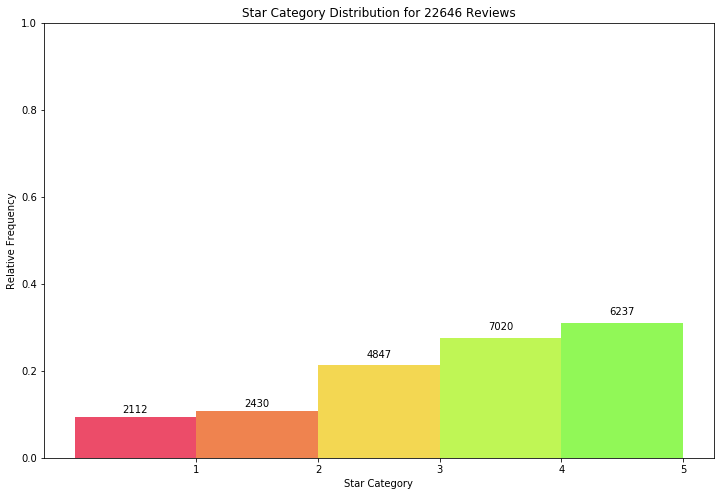

In [117]:
N_star_categories = 5
colors = np.array(['#E50029', '#E94E04', '#EEC708', '#A5F30D', '#62F610']) # 1, 2, 3, 4, and 5 stars respectively
stars_labels = np.array([x_stars+1 for x_stars in range(N_star_categories)])
star_category_dist_fig = plt.figure(figsize=(12,8))
bar_plot_indices = np.arange(N_star_categories)
star_category_absolute_frequencies = df.overallStar.value_counts(ascending=True)
star_category_relative_frequencies = np.array(star_category_absolute_frequencies)/float(sum(star_category_absolute_frequencies))

rects = plt.bar(bar_plot_indices, star_category_relative_frequencies, width=1, color=colors, alpha=.7)
for (idx, rect) in enumerate(rects):
        plt.gca().text(rect.get_x()+rect.get_width()/2., 1.05*rect.get_height(), '%d'%int(star_category_absolute_frequencies[idx+1]),
                ha='center', va='bottom')


plt.xticks(bar_plot_indices+.5, stars_labels)
plt.xlabel('Star Category')
plt.ylabel('Relative Frequency')
plt.ylim([0,1])
plt.title('Star Category Distribution for {0} Reviews'.format(len(df)))

plt.show()

In [118]:
# How is the length of review related to Star Rating?
df['review_length'] = (df['pro'].str.len() + df['con'].str.len())/100

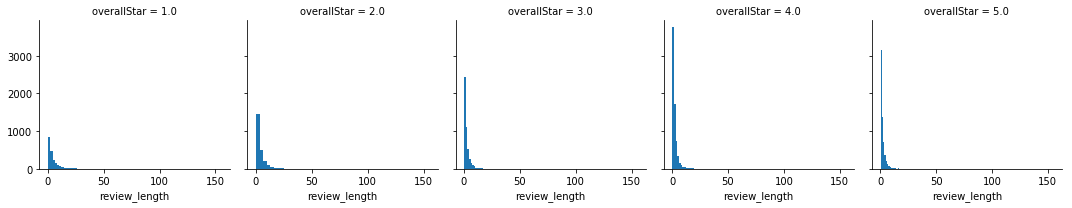

In [119]:
g = sns.FacetGrid(data=df, col='overallStar')
g.map(plt.hist, 'review_length', bins=50)

### Distribution of text length is similar across all five ratings. But number of reviews seems to be skewed a lot higher towards the 4-star and 5-star ratings

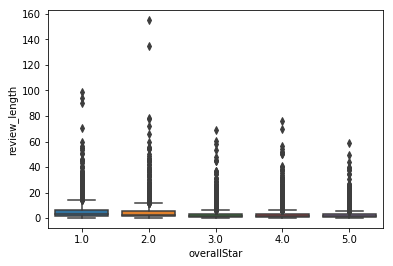

In [120]:
sns.boxplot(x='overallStar', y='review_length', data=df)

### From the plot, looks like the 1-star and 2-star ratings have much longer text, but there are many outliers (which can be seen as points above the boxes). Because of this, maybe text length won’t be such a useful feature to consider after all.

In [121]:
# trying to find correlations
stars = df.groupby('overallStar').mean()
stars.corr()

,Unnamed: 0,workLifeStar,cultureStar,careerOppStar,comBenefitsStar,srManagementStar,review_length
Unnamed: 0,1.000000,0.098762,0.098762,0.098762,0.098762,0.098762,-0.307880
workLifeStar,0.098762,1.000000,1.000000,1.000000,1.000000,1.000000,-0.929224
cultureStar,0.098762,1.000000,1.000000,1.000000,1.000000,1.000000,-0.929224
careerOppStar,0.098762,1.000000,1.000000,1.000000,1.000000,1.000000,-0.929224
comBenefitsStar,0.098762,1.000000,1.000000,1.000000,1.000000,1.000000,-0.929224
srManagementStar,0.098762,1.000000,1.000000,1.000000,1.000000,1.000000,-0.929224
review_length,-0.307880,-0.929224,-0.929224,-0.929224,-0.929224,-0.929224,1.000000


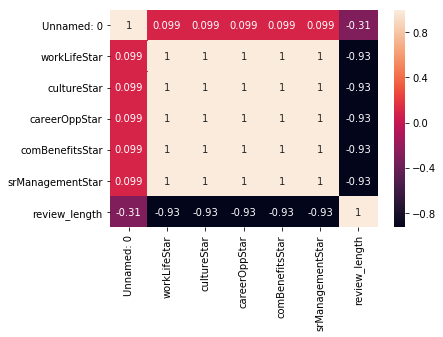

In [122]:
# To visualise these correlations, 
sns.heatmap(data=stars.corr(), annot=True)

In [123]:
# No surprises here, not much useful

Text(0.5,1,'Token Length vs Number of Reviews')

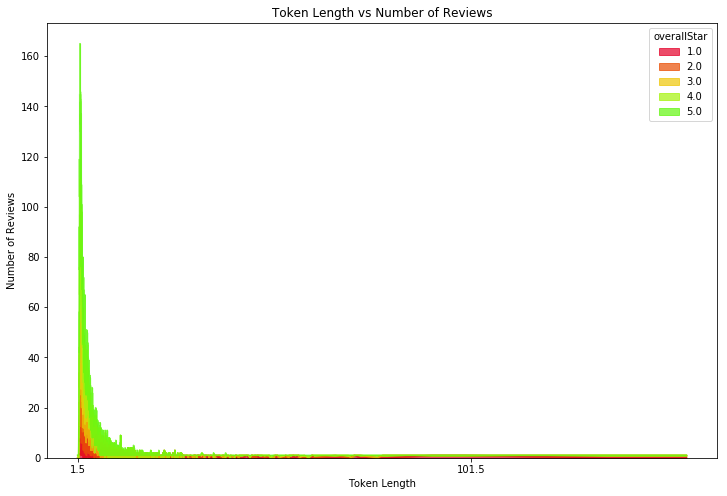

In [124]:
df['review_length'] = (df['pro'].str.len() + df['con'].str.len())
df['review_length_category'] = df.review_length.apply(lambda rl : rl/100)
df_with_initial_features_by_length_category_and_stars = df.groupby(['review_length_category', 'overallStar'])
star_count_by_review_length_and_category = df_with_initial_features_by_length_category_and_stars.size()
star_count_by_review_length_in_units_of_10 = star_count_by_review_length_and_category.unstack(level=1)
whereNaN = np.isnan(star_count_by_review_length_in_units_of_10)
star_count_by_review_length_in_units_of_10[whereNaN] = 0
star_count_by_review_length_in_units_of_10.plot(kind='area', figsize=(12,8), color=colors, alpha=0.7)

plt.xlabel('Token Length')
review_length_range = (min(df.review_length_category), max(df.review_length_category));
xtick_labels = 10*np.arange(review_length_range[0], review_length_range[1], 10);
x = np.arange(review_length_range[0], review_length_range[1], 100);
plt.xticks(x, xtick_labels);

plt.ylabel('Number of Reviews')
plt.title('Token Length vs Number of Reviews')

In [125]:
df.rename(columns={"Unnamed: 0":'reviewNum'}, inplace=True)
df.columns

Index(['reviewNum', 'date', 'reviewNo', 'employeeType', 'position', 'summary',
       'pro', 'con', 'advice', 'overallStar', 'workLifeStar', 'cultureStar',
       'careerOppStar', 'comBenefitsStar', 'srManagementStar', 'reviewLink',
       'review_length', 'review_length_category'],
      dtype='object')

In [126]:
# clean_text
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
STOPLIST = set(["n't", "'s", "'m", "ca", "'", "'re", "i've", 'poor', '-',
                'worst', 'place', 'make', 'thing', 'hour', 'low', 'high', 'bos',
                'good', 'great', 'awesome', 'excellent', 'job', 'best', 'lot',
                'wonderful', 'awful', 'work', 'amazing', 'suck', 'nice',
                'really', 'free', 'like', 'love', 'bad', 'terrible', 'care',
                'horrible', 'company', 'employee', 'staff', 'time', 'day',
                'week', 'month', 'year', 'need', 'better', 'just', 'decent', 'I', 'me', 'my', 'My', 'PRON'] +
               list(ENGLISH_STOP_WORDS))

In [127]:
KEEP_POS = {'ADJ', 'ADP', 'ADV', 'NOUN', 'VERB'}
nlp = spacy.load('en')


In [128]:
def multi_scrub_text(reviews):
    '''
    Function to lemmatize text - utilizes multiprocessing for parallelization
    INPUT:
        reviews: array-like, pandas DataFrame column containing review texts
    OUTPUT:
        lemmatized: pandas DataFrame column with cleaned texts
    '''
    lemmatized = []
    cpus = cpu_count() - 1
    pool = Pool(processes=cpus)
    lemmatized = pool.map(lemmatize_text, reviews)
    pool.close()
    pool.join()
    return lemmatized


def lemmatize_text(text, stop_words=STOPLIST, keep_pos=KEEP_POS):
    '''
    Function to lemmatize a single document of the corpus
    INPUT:
        text: string, text of review
        stop_words: words to remove from text, default STOPLIST defined above
        keep_pos: parts of speech to keep in text, default KEEP_POS def above
    OUTPUT:
        lemmatized text
    '''
    x = nlp(text)
    words = [tok.lemma_.strip(punctuation) for tok in x if (
        tok.pos_ in keep_pos) and (tok.lemma_.strip(punctuation) not in STOPLIST)]
    words.extend(['boss' for tok in x if tok.lemma_ == 'bos'])
    return ' '.join(words)

In [131]:
pros_df = pd.DataFrame()
cons_df = pd.DataFrame()

#pros_df['lemmatized_text'] = multi_scrub_text(df['pro'])

#cons_df['lemmatized_text'] = multi_scrub_text(df['con'])

In [132]:
df['lem_pro'] = multi_scrub_text(df['pro'])
df['lem_con'] = multi_scrub_text(df['con'])

In [133]:
df.head()

,reviewNum,date,reviewNo,employeeType,position,summary,pro,con,advice,overallStar,workLifeStar,cultureStar,careerOppStar,comBenefitsStar,srManagementStar,reviewLink,review_length,review_length_category,lem_pro,lem_con
0,1,"Feb 7, 2017",empReview_13664891,Current Employee - Software Development Engineer,I have been working at Amazon (More than a year),Kinda crappy,* Pay is good* Non idiotic approach to enginee...,* The company activly encourages everyone to t...,"I'm used to work being something like ""Hello _...",3.0,3.0,3.0,3.0,3.0,3.0,https://www.glassdoor.com/Reviews/Amazon-Revie...,1591,15.91,pay non idiotic approach engineering learn eng...,activly encourage treat inhuman tool crappy le...
1,2,"Mar 1, 2017",empReview_13996510,Former Employee - Anonymous Employee,I worked at Amazon part-time,Fulfillment,"Great coworkers, always moving, and easy work .",Can be held over for up to 2 additional hours.,Stop employees from hiding in the restroom .,4.0,4.0,4.0,4.0,4.0,4.0,https://www.glassdoor.com/Reviews/Amazon-Revie...,93,0.93,coworker easy,hold additional
2,3,"Mar 1, 2017",empReview_13997995,Current Employee - Anonymous Employee,None,Good company if you do your job,Decent pay for a job that isn't too hard.,If you don't like long days with little notice...,Management should be a little more compassiona...,4.0,4.0,4.0,4.0,4.0,4.0,https://www.glassdoor.com/Reviews/Amazon-Revie...,122,1.22,pay hard,long little notice schedule change bother
3,4,"Mar 15, 2017",empReview_14192639,Current Employee - Anonymous Employee,I have been working at Amazon full-time,Fulfillment associate,If you're late you can use your personal time ...,It breaks and lunch should be longer because o...,mayfair and just with the employees and follow...,3.0,3.0,3.0,3.0,3.0,3.0,https://www.glassdoor.com/Reviews/Amazon-Revie...,263,2.63,late use personal clock half unpaid lunch minu...,break lunch long pressure rate meet processing...
4,5,"Mar 15, 2017",empReview_14199877,Former Employee - Anonymous Employee,I worked at Amazon full-time,Fulfillment Associate,"Easy job, but not much else",Hours are pretty damn brutal,None,3.0,3.0,3.0,3.0,3.0,3.0,https://www.glassdoor.com/Reviews/Amazon-Revie...,55,0.55,easy,pretty damn brutal


# Lets find out what employees find most positive and most negative about the company
- Lets plot word frequency graph 
- Lets plot wordcloud

In [134]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS

def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [135]:
from collections import Counter
from nltk.tokenize import RegexpTokenizer
#from stop_words import get_stop_words
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

top_N = 100
#convert list of list into text
#a=''.join(str(r) for v in df_usa['title'] for r in v)

a = df['lem_pro'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
b = re.sub('[^A-Za-z]+', ' ', a)

#remove all the stopwords from the text
#stop_words = list(get_stop_words('en'))         
#nltk_words = list(stopwords.words('english'))   
#stop_words.extend(nltk_words)

word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in STOPLIST]
filtered_sentence = []
for w in word_tokens:
    if w not in STOPLIST:
        filtered_sentence.append(w)

# Remove characters which have length less than 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        

# Calculate frequency distribution
word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])


# Word Frequency count on positive reviews

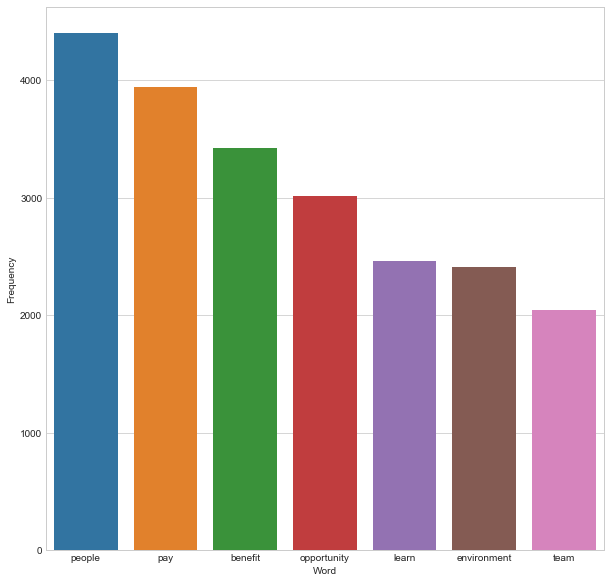

In [136]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

# Word Cloud on Pros

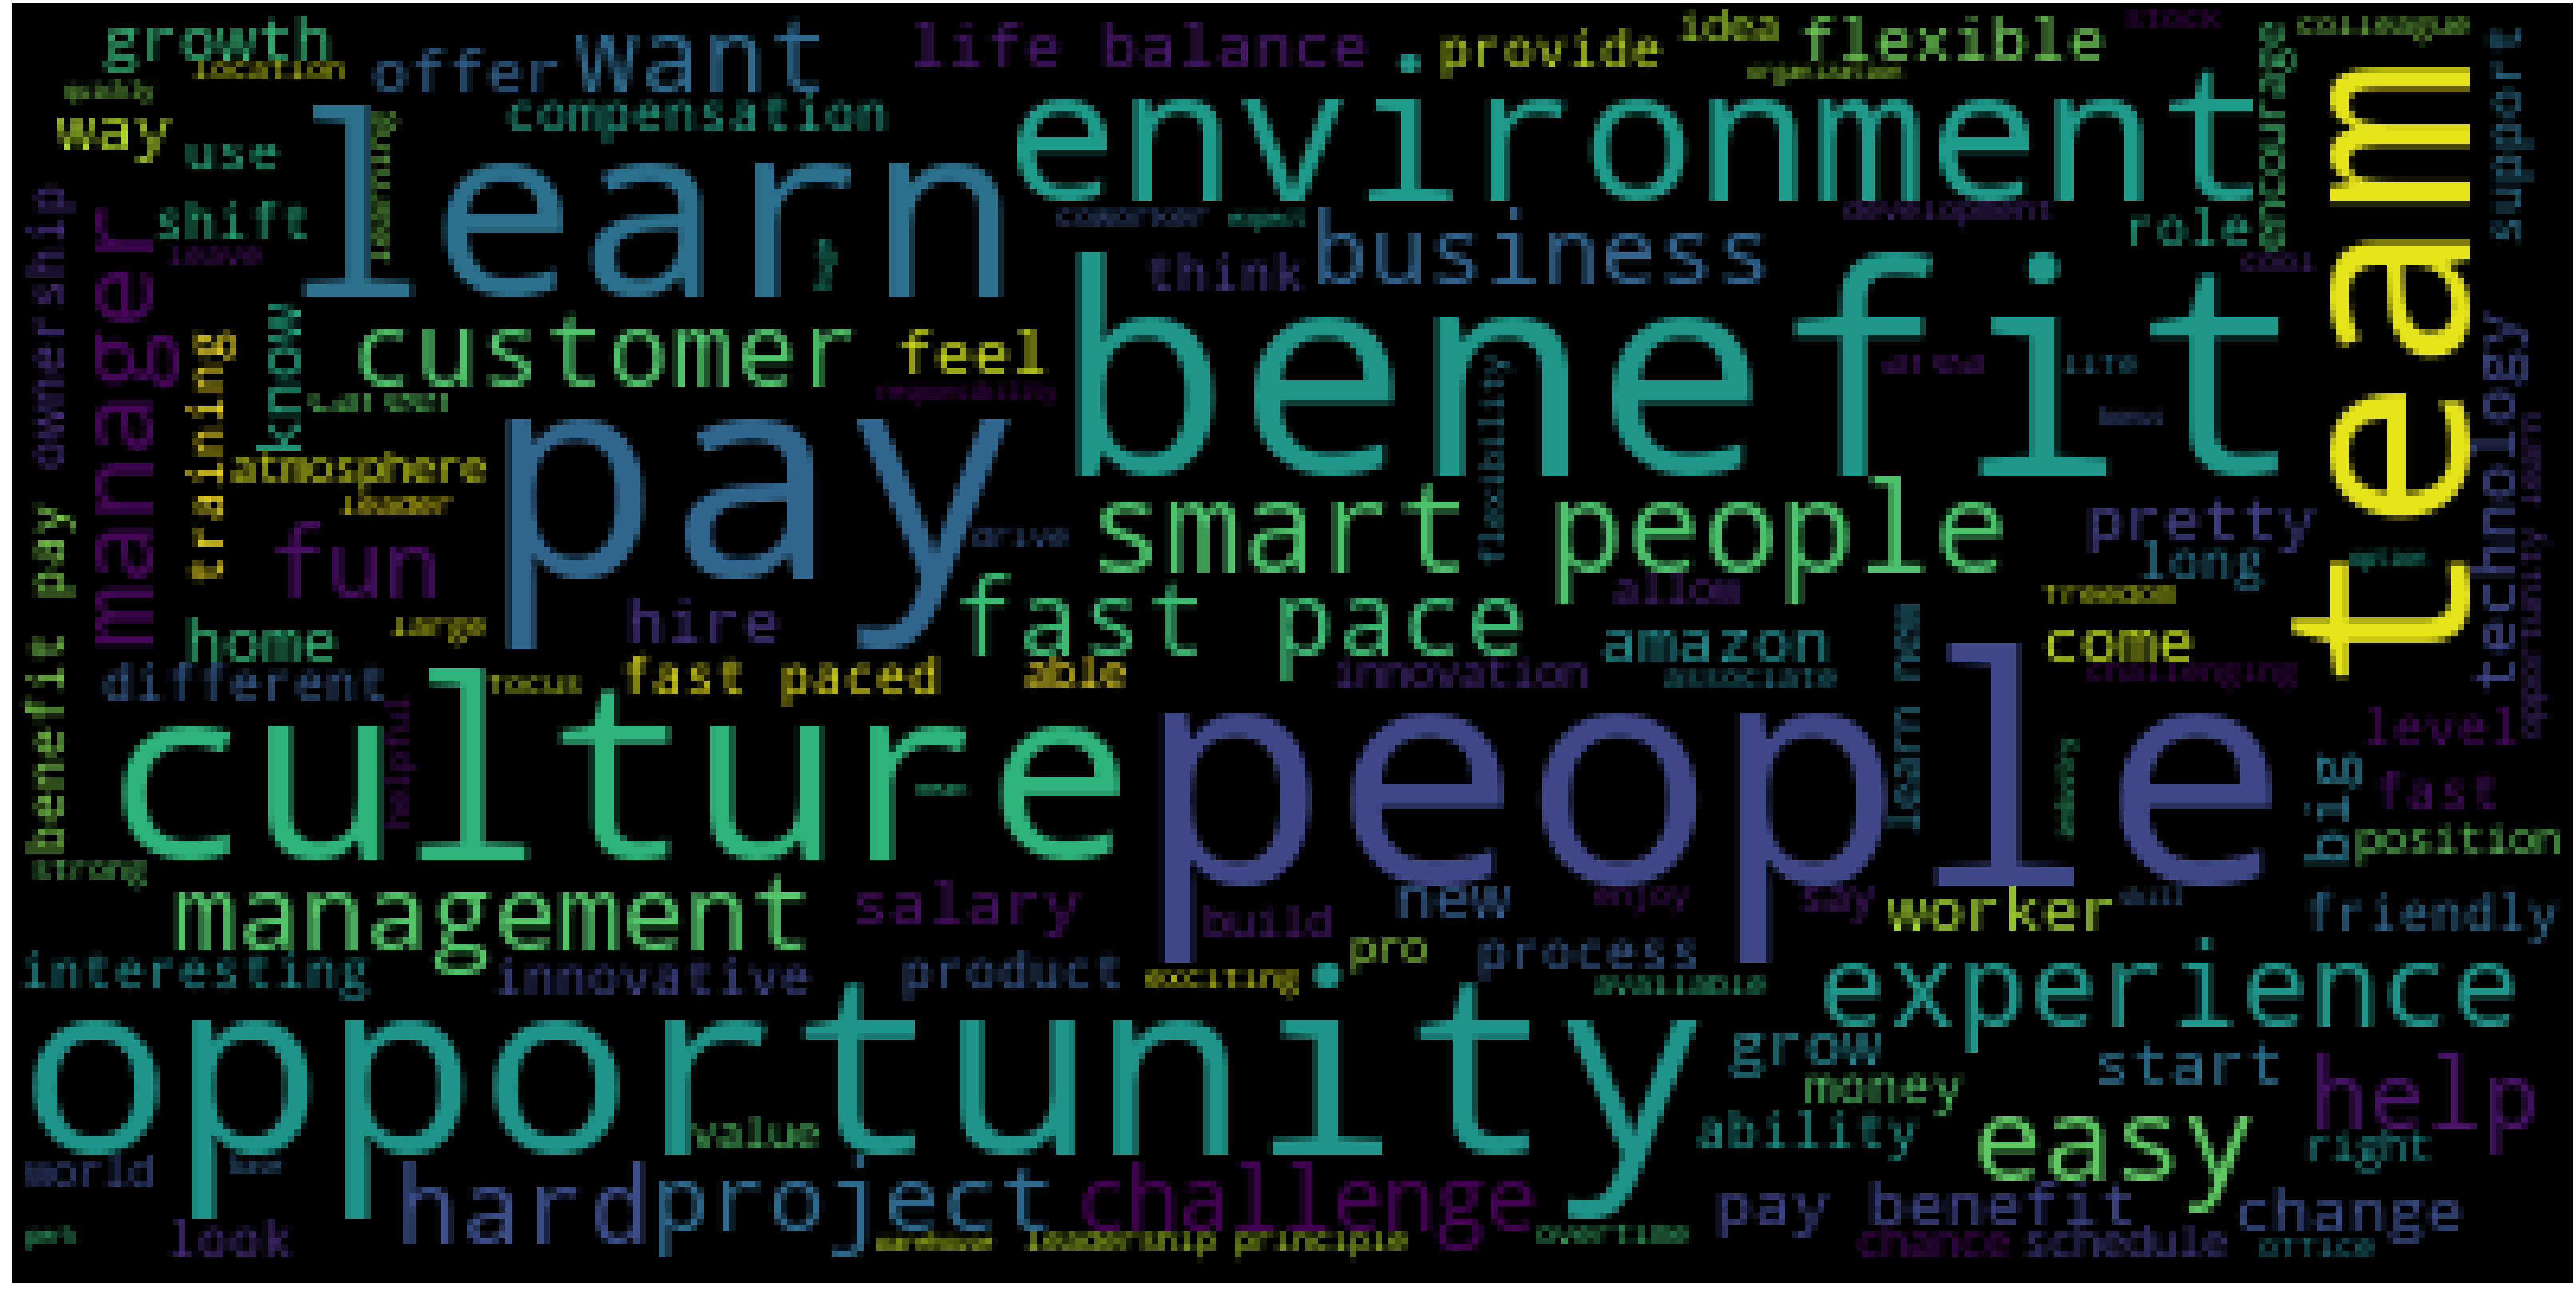

In [137]:
wc(cleaned_data_title,'black','Common Words' )

In [138]:
top_N = 100
#convert list of list into text

a = df['lem_con'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
b = re.sub('[^A-Za-z]+', ' ', a)

#remove all the stopwords from the text
#stop_words = list(get_stop_words('en'))         
#nltk_words = list(stopwords.words('english'))   
#stop_words.extend(nltk_words)

word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in STOPLIST]
filtered_sentence = []
for w in word_tokens:
    if w not in STOPLIST:
        filtered_sentence.append(w)

# Remove characters which have length less than 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        

# Calculate frequency distribution
word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

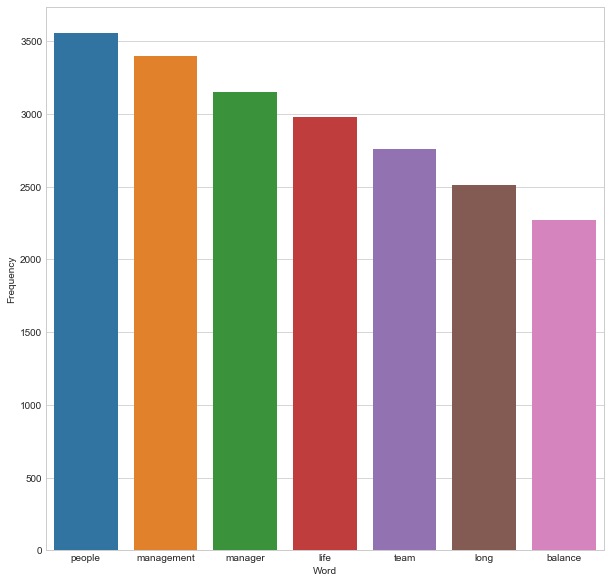

In [139]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

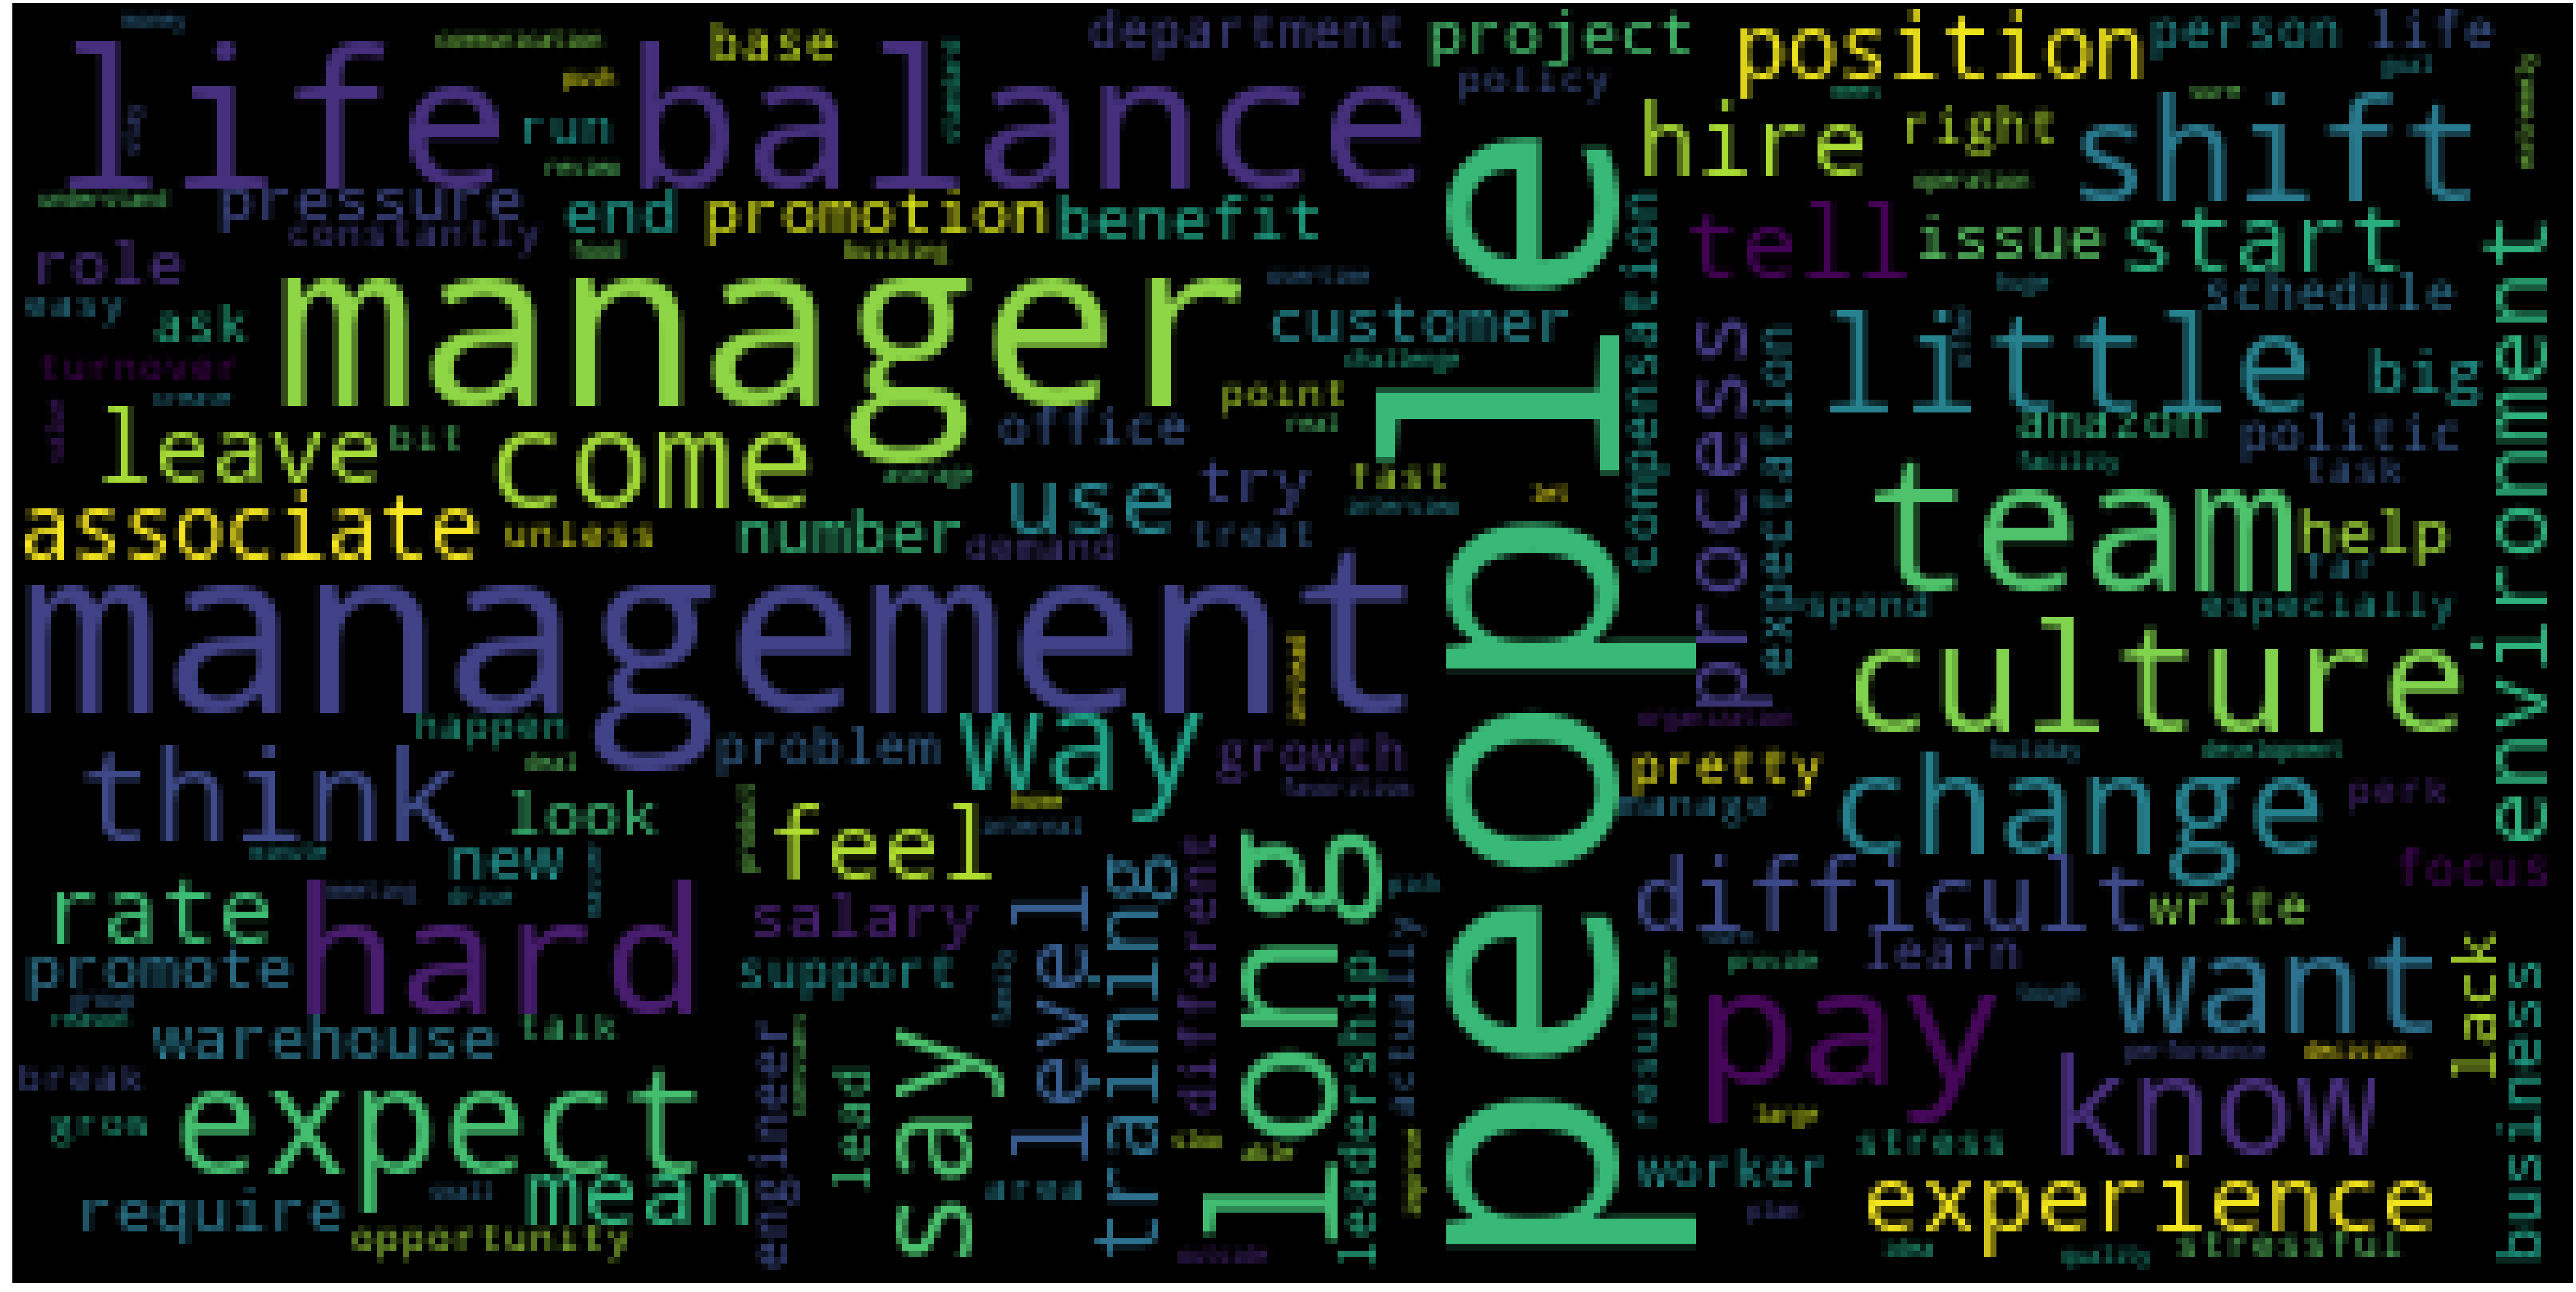

In [140]:
wc(cleaned_data_title,'black','Common Words' )

# Analyze sentiment of positive reviews

In [141]:
from textblob import TextBlob

In [142]:
txt_pro = df['pro'].str.lower().str.cat(sep=' ')
blob = TextBlob(txt_pro)
#print (blob)

In [143]:
blob.sentiment

Sentiment(polarity=0.34197689340867093, subjectivity=0.5739943073369556)

In [144]:
txt_con = df['con'].str.lower().str.cat(sep=' ')
blob = TextBlob(txt_con)
print (blob)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [145]:
blob.sentiment

Sentiment(polarity=0.033926443265957604, subjectivity=0.49576194084868047)

# Does lematized review improve the sentiment polarity?

In [146]:
txt_pro = df['lem_pro'].str.lower().str.cat(sep=' ')
blob = TextBlob(txt_pro)
blob.sentiment

Sentiment(polarity=0.16945874949009246, subjectivity=0.5453465064593608)

In [147]:
txt_pro = df['lem_con'].str.lower().str.cat(sep=' ')
blob = TextBlob(txt_pro)
blob.sentiment

Sentiment(polarity=-0.023151551916701745, subjectivity=0.5118929678973424)

In [148]:
# Well, apparently, lematization does not help with sentiment function

In [149]:
df.overallStar.value_counts()

4.0    7020
5.0    6237
3.0    4847
2.0    2430
1.0    2112
Name: overallStar, dtype: int64

In [150]:
df['review'] = df['pro']  + df['con']
df['length'] = df['review'].apply(len)
df.head()

,reviewNum,date,reviewNo,employeeType,position,summary,pro,con,advice,overallStar,...,careerOppStar,comBenefitsStar,srManagementStar,reviewLink,review_length,review_length_category,lem_pro,lem_con,review,length
0,1,"Feb 7, 2017",empReview_13664891,Current Employee - Software Development Engineer,I have been working at Amazon (More than a year),Kinda crappy,* Pay is good* Non idiotic approach to enginee...,* The company activly encourages everyone to t...,"I'm used to work being something like ""Hello _...",3.0,...,3.0,3.0,3.0,https://www.glassdoor.com/Reviews/Amazon-Revie...,1591,15.91,pay non idiotic approach engineering learn eng...,activly encourage treat inhuman tool crappy le...,* Pay is good* Non idiotic approach to enginee...,1591
1,2,"Mar 1, 2017",empReview_13996510,Former Employee - Anonymous Employee,I worked at Amazon part-time,Fulfillment,"Great coworkers, always moving, and easy work .",Can be held over for up to 2 additional hours.,Stop employees from hiding in the restroom .,4.0,...,4.0,4.0,4.0,https://www.glassdoor.com/Reviews/Amazon-Revie...,93,0.93,coworker easy,hold additional,"Great coworkers, always moving, and easy work ...",93
2,3,"Mar 1, 2017",empReview_13997995,Current Employee - Anonymous Employee,None,Good company if you do your job,Decent pay for a job that isn't too hard.,If you don't like long days with little notice...,Management should be a little more compassiona...,4.0,...,4.0,4.0,4.0,https://www.glassdoor.com/Reviews/Amazon-Revie...,122,1.22,pay hard,long little notice schedule change bother,Decent pay for a job that isn't too hard.If yo...,122
3,4,"Mar 15, 2017",empReview_14192639,Current Employee - Anonymous Employee,I have been working at Amazon full-time,Fulfillment associate,If you're late you can use your personal time ...,It breaks and lunch should be longer because o...,mayfair and just with the employees and follow...,3.0,...,3.0,3.0,3.0,https://www.glassdoor.com/Reviews/Amazon-Revie...,263,2.63,late use personal clock half unpaid lunch minu...,break lunch long pressure rate meet processing...,If you're late you can use your personal time ...,263
4,5,"Mar 15, 2017",empReview_14199877,Former Employee - Anonymous Employee,I worked at Amazon full-time,Fulfillment Associate,"Easy job, but not much else",Hours are pretty damn brutal,None,3.0,...,3.0,3.0,3.0,https://www.glassdoor.com/Reviews/Amazon-Revie...,55,0.55,easy,pretty damn brutal,"Easy job, but not much elseHours are pretty da...",55


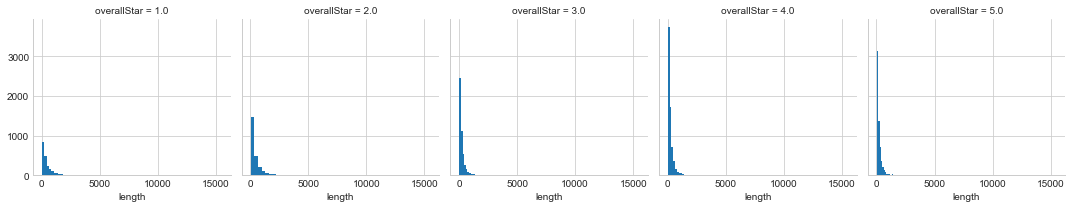

In [151]:
# Is there a correlation between review length & rating?
import seaborn as sns
g = sns.FacetGrid(data=df, col='overallStar')
g.map(plt.hist, 'length', bins=50)
# It does appear that people with higher rating write longer reviews and data is skewed towards positive reviews

In [152]:
# visualizing correlations in dataframe
stars = df.groupby('overallStar').mean()
stars.corr()

,reviewNum,workLifeStar,cultureStar,careerOppStar,comBenefitsStar,srManagementStar,review_length,review_length_category,length
reviewNum,1.000000,0.098762,0.098762,0.098762,0.098762,0.098762,-0.307880,-0.307880,-0.307880
workLifeStar,0.098762,1.000000,1.000000,1.000000,1.000000,1.000000,-0.929224,-0.929224,-0.929224
cultureStar,0.098762,1.000000,1.000000,1.000000,1.000000,1.000000,-0.929224,-0.929224,-0.929224
careerOppStar,0.098762,1.000000,1.000000,1.000000,1.000000,1.000000,-0.929224,-0.929224,-0.929224
comBenefitsStar,0.098762,1.000000,1.000000,1.000000,1.000000,1.000000,-0.929224,-0.929224,-0.929224
srManagementStar,0.098762,1.000000,1.000000,1.000000,1.000000,1.000000,-0.929224,-0.929224,-0.929224
review_length,-0.307880,-0.929224,-0.929224,-0.929224,-0.929224,-0.929224,1.000000,1.000000,1.000000
review_length_category,-0.307880,-0.929224,-0.929224,-0.929224,-0.929224,-0.929224,1.000000,1.000000,1.000000
length,-0.307880,-0.929224,-0.929224,-0.929224,-0.929224,-0.929224,1.000000,1.000000,1.000000


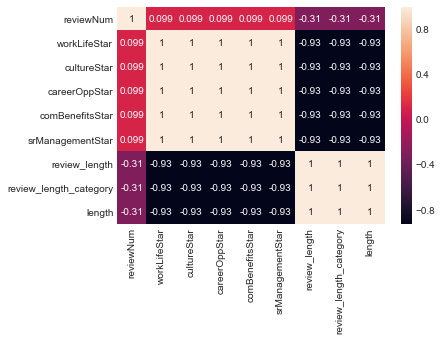

In [153]:
sns.heatmap(data=stars.corr(), annot=True)
# not useful at all

# Predictions
- Goal is to predict rating or classify review as positive or negative

In [154]:
from sklearn.metrics import confusion_matrix, classification_report
df.shape

(22646, 22)

In [155]:
# lets create X & Y for our classification task
X = df['review']
y = df['overallStar']

# 1. Baseline Model
Assign average rating as the predicted rating.

In [156]:

df['predicted_rating'] = round(sum(df.overallStar)/len(df.index))

print ("Baseline Rating:", round(sum(df.overallStar)/len(df.index)))

Baseline Rating: 4


In [157]:
t = df[['overallStar', 'predicted_rating']]

In [159]:
# We need to create a feature vector out of review text using bag of words and vectorization so that we can classify
import string
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [160]:
 # Use CountVectorizer to convert the text collection into a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer
bow_t = CountVectorizer(analyzer=text_process).fit(X)
len(bow_t.vocabulary_)

62562

In [162]:
bow_25 = bow_t.transform([review_25])
print(bow_25)

  (0, 4909)	1
  (0, 19738)	1
  (0, 36072)	1
  (0, 37181)	1
  (0, 45194)	1
  (0, 60732)	1


In [164]:
X = bow_t.transform(X)

In [165]:
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)
# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (22646, 62562)
Amount of Non-Zero occurrences:  611682
Density: 0.04317412790205483


In [166]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [167]:
# Multinomial Naive Bayes is a specialised version of Naive Bayes designed more for text documents.
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [168]:
# Testing and evaluating our model
preds = nb.predict(X_test)
# let’s evaluate our predictions against the actual ratings using confusion_matrix and classification_report 
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[ 258   54  164  166   37]
 [ 117   36  205  329   65]
 [  59   34  332  797  190]
 [  36   19  232 1325  469]
 [  23    8  132  866  841]]


             precision    recall  f1-score   support

        1.0       0.52      0.38      0.44       679
        2.0       0.24      0.05      0.08       752
        3.0       0.31      0.24      0.27      1412
        4.0       0.38      0.64      0.48      2081
        5.0       0.52      0.45      0.48      1870

avg / total       0.40      0.41      0.39      6794



In [169]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
    
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[ 56  20 140 263 200]
 [ 38  17 158 332 207]
 [ 40  16 322 653 381]
 [ 51  27 403 945 655]
 [ 32  25 306 747 760]]


             precision    recall  f1-score   support

        1.0       0.26      0.08      0.12       679
        2.0       0.16      0.02      0.04       752
        3.0       0.24      0.23      0.23      1412
        4.0       0.32      0.45      0.38      2081
        5.0       0.34      0.41      0.37      1870

avg / total       0.29      0.31      0.28      6794



In [170]:
clfs = [KNeighborsClassifier(), MultinomialNB(), LogisticRegression(), RandomForestClassifier(n_estimators=100, n_jobs=2), AdaBoostClassifier(n_estimators=100)]
clf_names = ['Nearest Neighbors', 'Multinomial Naive Bayes', 'Random Forest', 'Logistic Regression', 'AdaBoost']

LDAResults = {}
for (i, clf_) in enumerate(clfs):
    clf = clf_
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    print(clf_)
    print(confusion_matrix(y_test, preds))
    print('\n')
    print(classification_report(y_test, preds))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
[[ 56  20 140 263 200]
 [ 38  17 158 332 207]
 [ 40  16 322 653 381]
 [ 51  27 403 945 655]
 [ 32  25 306 747 760]]


             precision    recall  f1-score   support

        1.0       0.26      0.08      0.12       679
        2.0       0.16      0.02      0.04       752
        3.0       0.24      0.23      0.23      1412
        4.0       0.32      0.45      0.38      2081
        5.0       0.34      0.41      0.37      1870

avg / total       0.29      0.31      0.28      6794

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
[[ 258   54  164  166   37]
 [ 117   36  205  329   65]
 [  59   34  332  797  190]
 [  36   19  232 1325  469]
 [  23    8  132  866  841]]


             precision    recall  f1-score   support

        1.0       0.52      0.38      0.44       679
        2.0       0.24      0.05   

In [171]:
# Add sentiment label which will be used to train sentiment classifier
def getSentiment(x):
    if x < 3.5:
        return 0
    else:
        return 1
# 1 is positive and 0 is not positive or negative

In [172]:
df['Sentiment'] = df['overallStar'].map(getSentiment)
# lets create X & Y for our classification task
X = df['review']
y = df['Sentiment']
bow_t = CountVectorizer(analyzer=text_process).fit(X)
X = bow_t.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
nb = MultinomialNB()
nb.fit(X_train, y_train)
# Testing and evaluating our model
preds = nb.predict(X_test)
# let’s evaluate our predictions against the actual ratings using confusion_matrix and classification_report 
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))
# Predicting whether review is positive or negative is definitely more accurate than actual rating 1-5

[[1679 1164]
 [ 701 3250]]


             precision    recall  f1-score   support

          0       0.71      0.59      0.64      2843
          1       0.74      0.82      0.78      3951

avg / total       0.72      0.73      0.72      6794



In [181]:
negative_review_transformed = bow_t.transform([negative_review])
nb.predict(negative_review_transformed)[0]

0

In [182]:
# As expected, this is a negative review, correctly predicted

In [184]:
positive_review = df['review'][1]
print(positive_review)
print(df['Sentiment'][1]) 

Great coworkers, always moving, and easy work .Can be held over for up to 2 additional hours.
1


In [185]:
positive_review_transformed = bow_t.transform([positive_review])
nb.predict(positive_review_transformed)[0]

1

In [ ]:
# As expected, this is a positive review, correctly predicted

# Next Steps
- Oversample the negative reviews to balanced bias towards the positive reviews
- Improve the sentiment classification model